# **Robot Learning – Reinforcement Learning**

The goal of this practical exercise is to implement a Reinforcement Learning algorithm to learn a policy that moves a robot to a goal position. The algorithm is the Q-learning algorithm.

## The Problem
The problem consists in finding the goal in a finite 2D environment that is closed and contains some obstacles.

**States and actions:** The size of the environment is 20x14=280 states. The robot can only do 4 different actions: {←, ↑, →, ↓} (not diagonal movements!). Therefore the size of the Q function will be 280x4=1120 cells.

**Dynamics:** The robot can be located in any free cell (not in the obstacle cells!). The function that describes the dynamics is very simple: the robot will move ONE cell per iteration to the direction of the action that we select, unless there is an obstacle or the wall in front of it, in which case it will
stay in the same position.

**Reinforcement function:** Since the goal is to reach the goal position as fast as possible, the reinforcement function will give -1 in all cells except in the goal cell, where the reward will be +1. The cell that contains the goal is (3,17).

## Data

Next you have the map that will be used as the environment for the Q-learning algorithm:

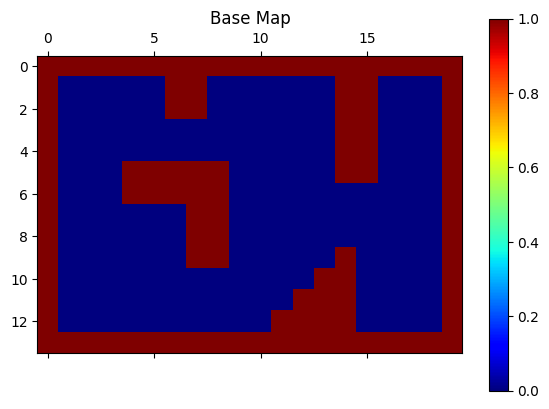

In [242]:
from matplotlib import pyplot as plt
import numpy as np

# Proposed Map
map=[
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
[1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


# Convert Map 2D array to Numpy array
grid_map = np.array(map)

# Show grid map
plt.matshow(grid_map, cmap = "jet")
plt.title('Base Map')
plt.colorbar()

plt.show()

## Algorithm

In order to implement the Q-learning algorithm, you should follow the next pseudocode:

```verbatim
Initialize Q(s,a) to 0 or random
For n episodes:
    Initialize s randomly in any free cell
    repeat:
        Choose action 'a' following epsilon-greedy policy
        Take action a, observe r and s'
        Q(s,a) <- Q(s,a) + alpha * (r + gamma * max_a Q(s',a)) - Q(s,a)
        s <- s'
    until the episode terminates
endFor
```

You will have to set several parameters experimentally: n, m, epsilon, alpha and gamma.

## Environment

In the environment class, you set the possible actions, the rewards obtained depending of those actions and the state of the agent after the action is applied.

You have to fill the empty functions following the previous pseudocode.

In [243]:
from matplotlib import pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class MapEnv:
    def __init__(self, map, goal, max_steps):
        self.map = map
        self.current_state = None
        self.goal = goal.astype(np.int32)
        self.actions = 4
        self.steps = 0
        self.max_steps = max_steps
        if map[goal[0], goal[1]] != 0:
            raise ValueError("Goal position is an obstacle")

    def reset(self):
        # start the agent in a random position within the map and return agent state (cell in which it is)
        self.steps = 0
        free_cells = np.argwhere(self.map == 0)
        if len(free_cells) == 0:
            raise ValueError("Map contains no free cells to place the agent.")
        r = free_cells[np.random.choice(len(free_cells))]

        self.current_state = tuple(r)
        return self.current_state
 

    def step(self, action):
      # this function applies the action taken and returns the obtained state, a reward and a boolean that says if the episode has ended (max steps or goal reached) or not (any other case)
      # action: 0 = up, 1 = down, 2 = left, 3 = right
      ended = False
      reward = -1
      a = [(-1, 0), (1, 0),(0, -1),(0, 1)]

      x,y = self.get_state()
      new_state = self.current_state
      dx,dy = a[action]
      if 0 <= x+dx < self.map.shape[0] and 0 <= y+dy < self.map.shape[1] and self.map[x+dx,y+dy]!=1:
        
        new_state = x+dx,y+dy
        
        if new_state== tuple(self.goal): 
          reward = 1
          ended = True
        else: reward =-1

      if self.steps == self.max_steps:
        ended =True 
          
      self.current_state = new_state
      self.steps+=1

      return new_state,reward,ended

    def get_state(self):
      # returns current state
      return self.current_state

    def render(self, i=0):
        plt.clf()
        plt.matshow(self.map, cmap = "jet")
        plt.title('Map')
        plt.colorbar()
        plt.scatter(self.current_state[1], self.current_state[0], c = 'r')
        plt.scatter(self.goal[1], self.goal[0], c = 'g')
        # plt.savefig("q_learning_{0:04}.png".format(i), dpi = 300)
        # plt.show()
        plt.pause(0.1) 

    def render_live(self, i=0, episodic_reward=0, avg_reward=0, goal_reached=False,save_frames=False):
        clear_output(wait=True)  # Clear previous frame to create an animation effect

        if not hasattr(self, 'fig'):   
            self.fig, self.ax = plt.subplots()  
        else:
            self.ax.clear()  # Clear the previous plot
        
        # Draw the environment
        self.ax.imshow(self.map, cmap="jet")  
        self.ax.scatter(self.goal[1], self.goal[0], c='g')  # Goal
        self.ax.scatter(self.current_state[1], self.current_state[0], c='r')  # Agent
        
        # Display reward information
        if episodic_reward is not None:
            self.ax.text(0.05, 0.98, f"Episodic Reward: {int(episodic_reward)}", 
                        transform=self.ax.transAxes, fontsize=10, color="white",
                        verticalalignment="top", horizontalalignment="left", fontweight='bold')

        if avg_reward is not None:
            self.ax.text(0.65, 0.98, f"Average Reward: {int(avg_reward)}", 
                        transform=self.ax.transAxes, fontsize=10, color="white",
                        verticalalignment="top", horizontalalignment="left", fontweight='bold')

        if goal_reached:
            self.ax.text(0.4, 0.98, f"Goal Reached!", 
                        transform=self.ax.transAxes, fontsize=10, color="white",
                        verticalalignment="top", horizontalalignment="left", fontweight='bold')
        
        # Display the updated figure in Jupyter
        display(self.fig)
        plt.pause(0.10)  # Small pause to allow the figure to update
        if save_frames:
            self.fig.savefig(f'./plots/plot_{i}.png')


os.makedirs('./plots/', exist_ok=True)

## QLearning algorithm

QLearning class creates and trains the policy at every episode using the information provided by the environment. After the training is over, the optimal policy and the value function are obtained.

As in the MapEnv class, you have to fill the empty functions following the previous pseudocode.

In [244]:

import tqdm
from IPython.display import clear_output

class QLearning:
    def __init__(self, env, alpha, gamma, epsilon, n_episodes,visualize):
        self.avg_reward = 0
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_episodes = n_episodes 
        self.Q = np.random.rand(env.map.shape[0], env.map.shape[1], env.actions)

    def epsilon_greedy_policy(self, s, epsilon):
        # Epsilon greedy policy (choose a random action with probability epsilon)
        a = None
        r = np.random.rand()
        if r<=epsilon: a = np.random.choice(range(self.env.actions))
        else: a = np.argmax(self.Q[s]) #a = np.max(self.Q)
        return a
    
    def episode(self, alpha, epsilon,render=False):
        # Episode execution. Generate an action with epsilon_greedy_policy, call step, appy learning function
        # This function should return the total reward obtained in this episode
        # ...
        a = None
        episodic_reward = 0
        self.env.current_state= self.env.reset()
        prev_state = self.env.get_state()
        for step in range(self.env.max_steps):
            a = self.epsilon_greedy_policy(prev_state,epsilon)
            new_state,reward,ended = self.env.step(a)
            self.Q[prev_state[0],prev_state[1],a] = self.Q[prev_state[0],prev_state[1],a] + \
            alpha * (reward + self.gamma * np.max(self.Q[new_state[0],new_state[1],:]) - self.Q[prev_state[0],prev_state[1],a])

            # self.Q[prev_state[0],prev_state[1],a] =  self.Q[prev_state[0],prev_state[1],a] + \
            #     alpha*(reward+self.gamma*np.max(self.Q[new_state[0],new_state[1],:]))-self.Q[prev_state[0],prev_state[1],a]
            # print("prev_state",prev_state,"action:",a," next_state:",new_state)
            prev_state = new_state
            episodic_reward+=reward
            # print("epi_reward:",episodic_rewar
            if render:
                self.env.render_live(i = step, episodic_reward=episodic_reward,avg_reward=self.avg_reward,save_frames=False)
            if ended:
                break
        
        return episodic_reward

    def train(self, n_episodes, check_every_n=100,render=True):
        """Execute n_episodes and every `check_every_n` episodes print the average reward and store it.
           As the initial position is random, this number will not be super stable..."""
        reward = []
        for eps in tqdm.tqdm(range(n_episodes)):
            r = self.episode(self.alpha,self.epsilon,render)
            if eps%check_every_n==0:
                reward.append(r)
                self.avg_reward=sum(reward)/len(reward)
                # print("Average Reward:",sum(reward)/len(reward))
        print("Average Reward:",sum(reward)/len(reward))

    def test_episode(self,policy, save_frames=False):
        print("Testing Episode")
        # Episode execution. Generate an action with epsilon_greedy_policy, call step, appy learning function
        # This function should return the total reward obtained in this episode
        # ...
        a = None
        goal_reached=False
        episodic_reward = 0
        self.env.current_state= self.env.reset()
        prev_state = self.env.get_state()
        for step in range(self.env.max_steps): 
            a = policy[prev_state]
            new_state,reward,ended = self.env.step(a)
            prev_state = new_state
            episodic_reward+=reward
            # print("epi_reward:",episodic_reward)
            if new_state ==  tuple(self.env.goal):
                print("Goal Reached\n")
                goal_reached = True

            self.env.render_live(i = step, episodic_reward=episodic_reward,avg_reward=None,goal_reached=goal_reached,save_frames=save_frames)
            if ended:
                return step
                break

    def get_optimal_policy(self):
        """Once training is done, retrieve the optimal policy from Q(s,a)."""
        policy = np.zeros(self.env.map.shape, dtype=int)
        states = np.argwhere(self.env.map == 0)
        for s in states:
            opt_a = np.argmax(self.Q[s[0],s[1],:]) #in a particlar state check for best action
            policy[s[0],s[1]]=opt_a
        return policy

    def value_function(self):
        """Once training is done, retrieve the optimal value function from from Q(s,a)"""
        v = np.max(self.Q, axis = 2)
        v[self.env.map == 1] = -np.inf
        return v


## Training

For the training you need to choose some parameters experimentally. Test different values to see how the training results change.

Parameters:

* **alpha**: learning rate of the algorithm
* **gamma**: discount factor of the algorithm
* **epsilon**: random action probability
* **n_episodes**: number of episode repetitions
* **max_steps**: maximum number of iterations per episode (in Environment class)

In [245]:
# Create an environment and a QLearning agent to learn it. Plot the averaged rewards stored.
# print(np.shape(grid_map))
# Create an environment and a QLearning agent to learn it. Plot the averaged rewards stored.
eps=2000
eps_steps = 23
env = MapEnv(map=grid_map, goal=np.array([4, 4]), max_steps=eps_steps)
agent = QLearning(env, alpha=0.8, gamma=0.95, epsilon=0.5, n_episodes=eps, visualize=False)
agent.train(n_episodes=eps, check_every_n=eps/4, render=False)
optimal_policy = agent.get_optimal_policy()
optimal_value = agent.value_function()




100%|██████████| 2000/2000 [00:00<00:00, 5675.77it/s]

Average Reward: -23.0


## Plot value function and optimal policy

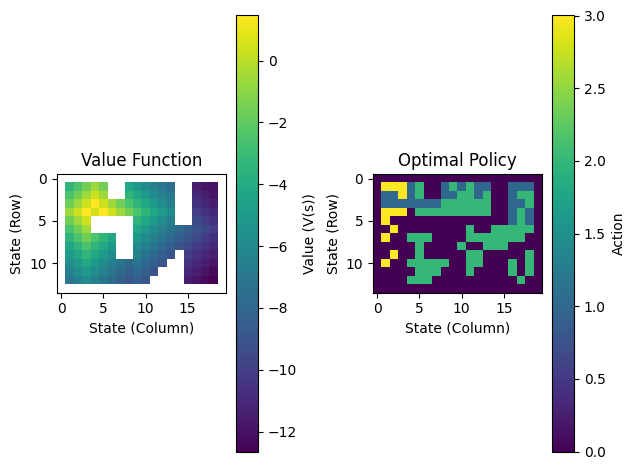

In [246]:
# Plot the value function (see included figure)
plt.subplot(1, 2, 1)
plt.imshow(optimal_value, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Value (V(s))")
plt.title("Value Function")
plt.xlabel("State (Column)")
plt.ylabel("State (Row)")

# Plot policy (see included figure)
plt.subplot(1, 2, 2)
plt.imshow(optimal_policy, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Action")
plt.title("Optimal Policy")
plt.xlabel("State (Column)")
plt.ylabel("State (Row)")

plt.tight_layout()
plt.show()

## Test current Policy

Once the training is over, we can see what the robot has learnt to do. You can test it with other goal positions and other maps, to see of the policy is able to adapt to other situations.

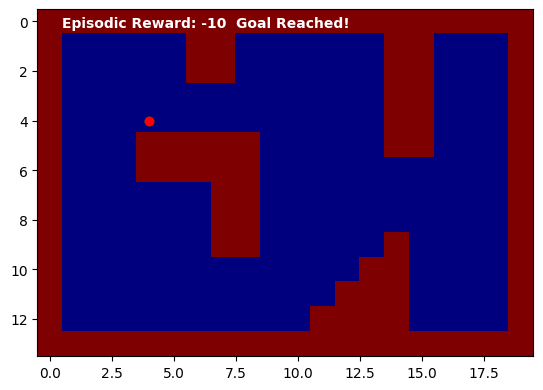

11

In [247]:
agent.test_episode(optimal_policy)

## Other environemnts

Create a new map (min size 15 x 15).

Answer:

* The policy you have just learned is able to solve this map?
* If not, the algorithm you have implemented is able to learn a new policy to solve this map? Demonstrate one or the other

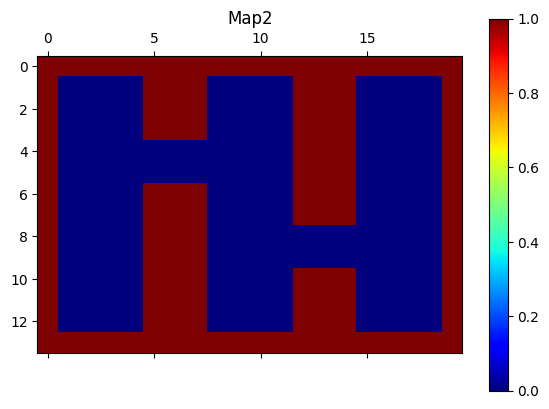

In [248]:
#  Map 2
map2=[
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


# Convert Map 2D array to Numpy array
grid_map2 = np.array(map2)

# Show grid map
plt.matshow(grid_map2, cmap = "jet")
plt.title('Map2')
plt.colorbar()
eps=2000
eps_steps = 23
env = MapEnv(map=grid_map, goal=np.array([4, 4]), max_steps=eps_steps)

plt.show()

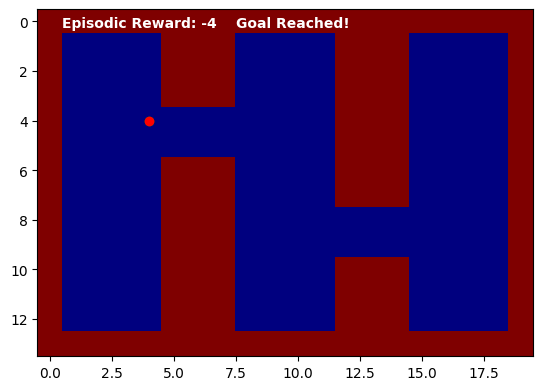

5

In [249]:
# testing old policy in new environment

#######################################################################################################
# IMPORTANT
# this code modifies the original agent enviroment. after training the agent with the first map, the agent is tested with the second map
# after running this codem, if you want to test the agent with the first map again, you need to re-run the agent training with the first map
#######################################################################################################
env2 = MapEnv(map=grid_map2, goal=np.array([4, 4]), max_steps=eps_steps)
agent.env = env2
agent.test_episode(optimal_policy)

## Creating a new model with the new environment

100%|██████████| 2000/2000 [00:00<00:00, 5440.96it/s]


Average Reward: -17.25


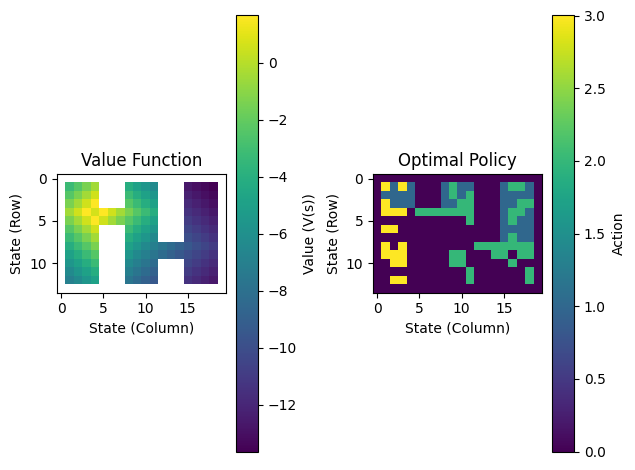

In [250]:

eps=2000
eps_steps = 33
#agent2 = QLearning(env2, alpha=0.02, gamma=0.95, epsilon=0.5, n_episodes=eps, visualize=False)
agent2 = QLearning(env2, alpha=0.8, gamma=0.95, epsilon=0.6, n_episodes=eps, visualize=False)
agent2.train(n_episodes=eps, check_every_n=eps/4, render=False)
optimal_policy2 = agent2.get_optimal_policy()
optimal_value2 = agent2.value_function()

# Plot the value function (see included figure)
plt.subplot(1, 2, 1)
plt.imshow(optimal_value2, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Value (V(s))")
plt.title("Value Function")
plt.xlabel("State (Column)")
plt.ylabel("State (Row)")

# Plot policy (see included figure)
plt.subplot(1, 2, 2)
plt.imshow(optimal_policy2, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Action")
plt.title("Optimal Policy")
plt.xlabel("State (Column)")
plt.ylabel("State (Row)")

plt.tight_layout()
plt.show()


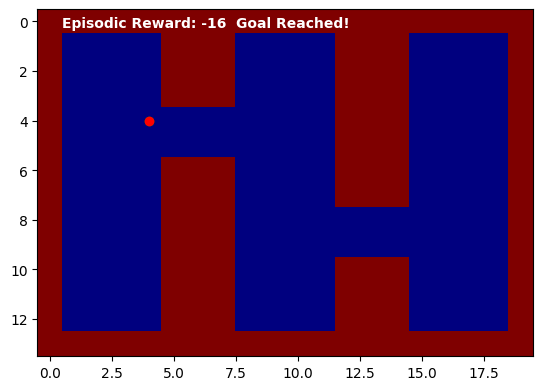

17

In [254]:
agent2.test_episode(optimal_policy2, save_frames=False)

## ultra complex map? not really ... 

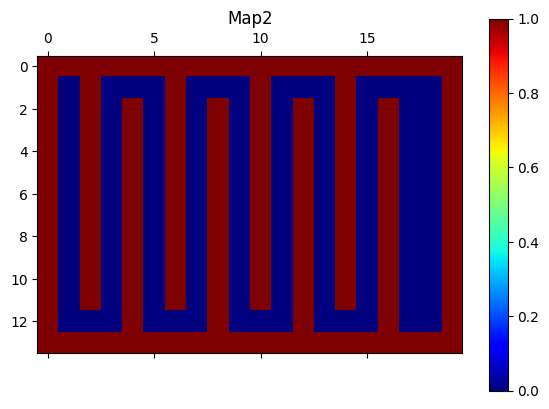

In [271]:
#  Map 3
map3=[
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1],
[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1],
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


# Convert Map 2D array to Numpy array
grid_map3 = np.array(map3)

# Show grid map
plt.matshow(grid_map3, cmap = "jet")
plt.title('Map2')
plt.colorbar()

plt.show()


100%|██████████| 2000/2000 [00:02<00:00, 964.14it/s] 


Average Reward: -143.75


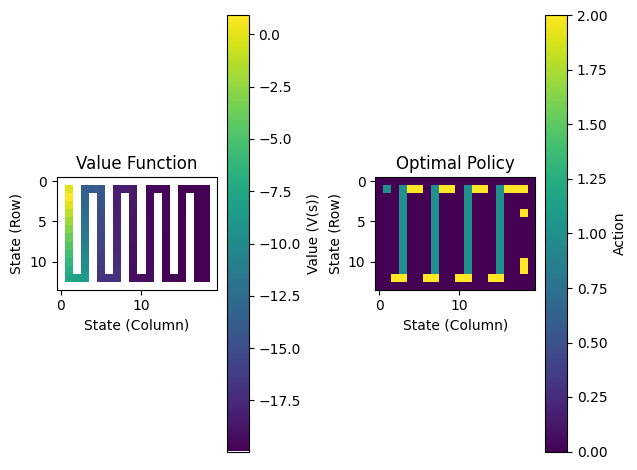

In [274]:
eps=2000
eps_steps = 150
env3 = MapEnv(map=grid_map3, goal=np.array([1, 1]), max_steps=eps_steps)

#agent2 = QLearning(env2, alpha=0.02, gamma=0.95, epsilon=0.5, n_episodes=eps, visualize=False)
agent3 = QLearning(env3, alpha=0.8, gamma=0.95, epsilon=0.6, n_episodes=eps, visualize=False)
agent3.train(n_episodes=eps, check_every_n=eps/4, render=False)
optimal_policy3 = agent3.get_optimal_policy()
optimal_value3 = agent3.value_function()

# Plot the value function (see included figure)
plt.subplot(1, 2, 1)
plt.imshow(optimal_value3, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Value (V(s))")
plt.title("Value Function")
plt.xlabel("State (Column)")
plt.ylabel("State (Row)")

# Plot policy (see included figure)
plt.subplot(1, 2, 2)
plt.imshow(optimal_policy3, cmap="viridis", interpolation="nearest")
plt.colorbar(label="Action")
plt.title("Optimal Policy")
plt.xlabel("State (Column)")
plt.ylabel("State (Row)")

plt.tight_layout()
plt.show()

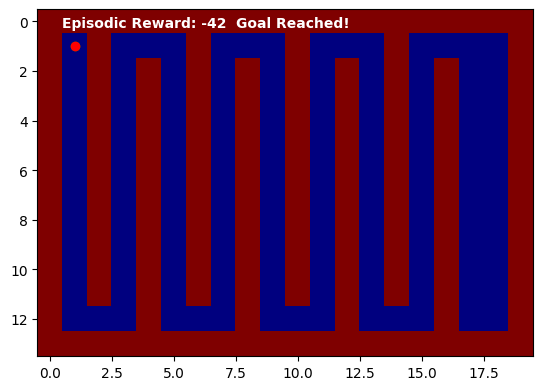

43

In [280]:
agent3.test_episode(optimal_policy3, save_frames=False)

## Submission

You must deliver this Python Interactive Notebook. The file must have the name q_learning_YOUR_NAME.ipynb. Also, you must do a report commenting the problems you encountered, a discussion on how the parameters affect the training and conclusions for the results obtained.

Make sure that all cells can be executed.